<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/Logo_UNIR.png" width="350" height="175">

# *TFM: Comparación y optimización de algoritmos de Machine Learning sobre el éxito de campañas de marketing bancarias*

Autor: ***Jorge López Pérez***

***

## ***6. Transformación de variables numéricas***

A lo largo de este cuaderno, veremos las diferentes posibilidades que tenemos a la hora de tratar de transformar las variables numéricas de nuestro dataset.

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

#metricas
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#imputers
from sklearn.impute import KNNImputer

#escalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer

warnings.filterwarnings("ignore")

In [ ]:
# leemos los datos limpios
data = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/clean_data.csv')
data.shape

(41176, 21)

Separamos los datos en train y test que utilizaremos hasta el final del estudio (utilizaremos stratify para tener el mismo porcentaje de instancias de cada clase en train y test):

In [ ]:
x,y = data.drop(['y'], axis=1), data['y'].copy()
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, stratify=y, random_state=44)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34999, 20)
(34999,)
(6177, 20)
(6177,)


***

#### 6.1 Pipeline

Definimos la pipeline que utilizaremos para variar las transformaciones realizadas según las pruebas que hagamos de manera rápida:

In [ ]:
numericas = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categoricas_nominal = ['job','marital', 'poutcome']
categoricas_ordinal = ['education', 'month', 'day_of_week']
categoricas_dicotomicas = ['default', 'housing', 'loan', 'contact']
total_columns = categoricas_ordinal + categoricas_nominal + categoricas_dicotomicas + numericas

def round_imputed_values(X):
    X_rounded = np.round(X)
    return X_rounded

cat_ordinal_transformer = Pipeline([
    ('encoder', OrdinalEncoder(categories=[
         ["basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree"],
         ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
         ["mon","tue","wed","thu","fri"]]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer', KNNImputer(n_neighbors=10)),
    ('rounding', FunctionTransformer(round_imputed_values))
])

cat_nominal_transformer = Pipeline([
     ('encoder_prev', OrdinalEncoder(categories=[
         ['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student'],
         ['married', 'single', 'divorced'],
         ['nonexistent', 'failure', 'success']
         ]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('imputer', KNNImputer(n_neighbors=10)),
     ('rounding', FunctionTransformer(round_imputed_values)),
     ('encoder', OneHotEncoder())
])

cat_dicotomico_transformer = Pipeline([
     ('encoder_prev', OrdinalEncoder(categories=[
         ['no', 'yes'],
         ['no', 'yes'],
         ['no', 'yes'],
         ['cellular', 'telephone']
         ]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('imputer', KNNImputer(n_neighbors=10)),
     ('rounding', FunctionTransformer(round_imputed_values)),
     ('encoder', OneHotEncoder())
])

numericas_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
        ('cat_ordinal', cat_ordinal_transformer, categoricas_ordinal),
        ('cat_nominal', cat_nominal_transformer, categoricas_nominal),
        ('cat_dicotomico', cat_dicotomico_transformer, categoricas_dicotomicas),
        ('numericas', numericas_transformer, numericas)
    ], remainder='passthrough')

pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

In [ ]:
label_encoder = LabelEncoder()
y_train_prepared = label_encoder.fit_transform(y_train)
y_test_prepared = label_encoder.transform(y_test)
print(y_train_prepared.shape)
print(y_test_prepared.shape)

(34999,)
(6177,)


In [ ]:
x_train_prepared = pipeline.fit_transform(x_train)
x_test_prepared = pipeline.transform(x_test)
print(x_train_prepared.shape)
print(x_test_prepared.shape)

(34999, 38)
(6177, 38)


Ejemplo muestra:

In [ ]:
x_train_prepared[0]

array([ 6.        ,  2.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.28870906,  0.72368775,
       -0.20632323,  0.1971915 , -0.34993744, -1.19619161, -1.17725058,
       -1.22926813, -1.33691279, -0.93918232])

***

#### 6.2 Ejemplo distribución scalers sobre 'age'

Plotearemos la distribución de age con los diferentes scalers (los iremos guardando en una lista) (quitaremos el onehot para poder localizar mejor las columnas):

In [ ]:
age_distributions = []

In [ ]:
df = pd.DataFrame(x_train_prepared, columns=total_columns)
age_distributions.append(df['age'])

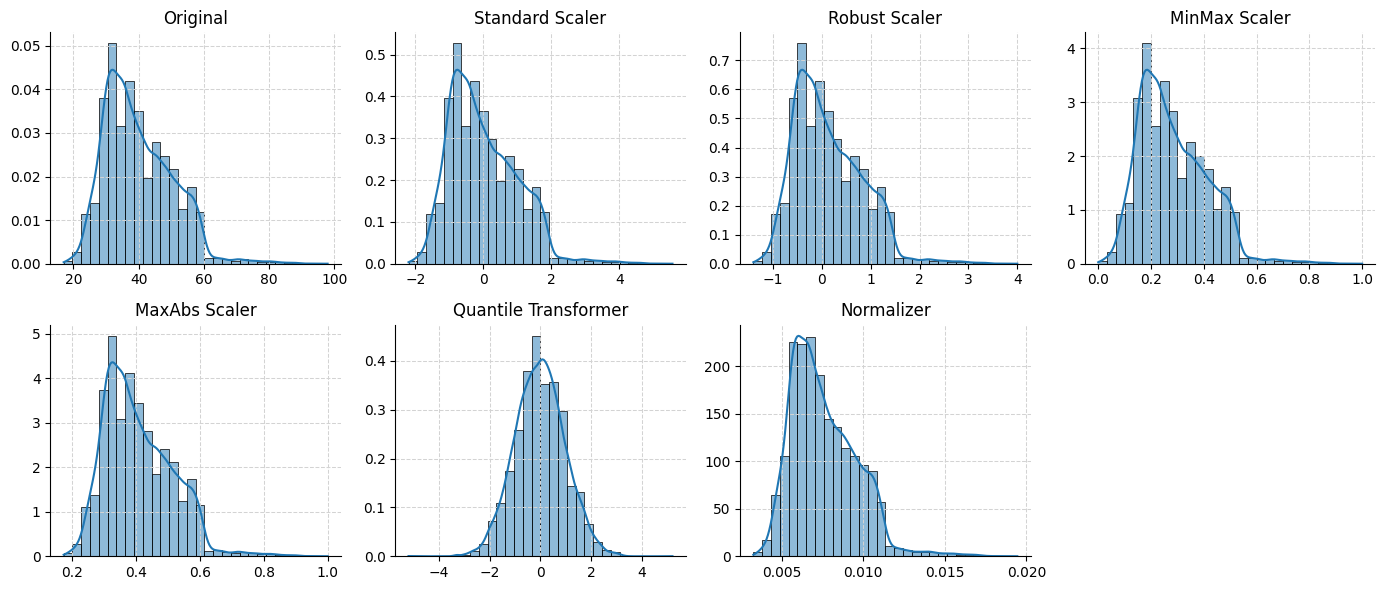

In [ ]:
titles = ['Original', 'Standard Scaler', 'Robust Scaler', 'MinMax Scaler', 'MaxAbs Scaler', 'Quantile Transformer', 'Normalizer']

num_rows = 2
num_cols = 4

total_plots = num_rows * num_cols
plt.figure(figsize=(14, num_rows * 3))

for idx, distribution in enumerate(age_distributions):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.histplot(data=distribution,kde=True, stat="density", bins=30)
    plt.grid(visible=True, which='both', linestyle='--', color='lightgrey', linewidth=0.75)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine(left=False, bottom=False, right=True, top=True)
    plt.title(f"{titles[idx]}")

plt.tight_layout()
plt.show()

***

#### 6.3 Modelos y cálculo de métricas

Definimos la arquitectura inicial de nuestra RN. Empezaremos con una arquitectura sencilla que optimizaremos cuando llegue el momento:

In [ ]:
def build_rn():
  inputs = keras.Input(shape=(x_train_prepared.shape[1],))

  hidden1 = keras.layers.Dense(32, activation='relu')(inputs)
  hidden2 = keras.layers.Dense(16, activation='relu')(hidden1)
  outputs = keras.layers.Dense(1, activation='sigmoid')(hidden2)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
def initialize_models():

  estimators = [
      ('lr', LogisticRegression(random_state=44)),
      ('dt', DecisionTreeClassifier(random_state=44)),
      ('kn', KNeighborsClassifier()),
      ('rn', KerasClassifier(model=build_rn, epochs=10, batch_size=32, verbose=0, random_state=44)),
      ('rf', RandomForestClassifier(random_state=44)),
      ('xgb', xgboost.XGBClassifier(random_state=44)),
      ('hist', HistGradientBoostingClassifier(random_state=44))
  ]

  dict_estimators = dict(estimators)

  voting = VotingClassifier(estimators=estimators, voting='soft')
  dict_estimators['voting'] = voting

  return dict_estimators

Funciones para cálculo de métricas:

In [ ]:
def probas_to_abs(probas, umbral=0.5):
  abs = []
  for proba in probas:
    if (proba >= umbral): abs.append(1)
    else: abs.append(0)
  return abs

def calculate_cv_metrics(estimator,x,y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  scores_auc_pr = []
  scores_precision = []
  scores_recall = []
  scores_f1 = []
  scores_accuracy = []
  scores_roc = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_test = model.predict_proba(X_test)[:,1]

    scores_auc_pr.append(average_precision_score(Y_test, preds_test))
    scores_precision.append(precision_score(Y_test, probas_to_abs(preds_test)))
    scores_recall.append(recall_score(Y_test, probas_to_abs(preds_test)))
    scores_f1.append(f1_score(Y_test, probas_to_abs(preds_test)))
    scores_accuracy.append(accuracy_score(Y_test, probas_to_abs(preds_test)))
    scores_roc.append(roc_auc_score(Y_test, preds_test))

  mean_auc_pr = round(np.mean(scores_auc_pr), 4)
  mean_precision = round(np.mean(scores_precision), 4)
  mean_recall = round(np.mean(scores_recall), 4)
  mean_f1 = round(np.mean(scores_f1), 4)
  mean_accuracy = round(np.mean(scores_accuracy), 4)
  mean_roc = round(np.mean(scores_roc), 4)

  return mean_auc_pr, mean_precision, mean_recall, mean_f1, mean_accuracy, mean_roc


def calculate_pr_cv():
  modelos = initialize_models()
  scores = []
  for key, model in modelos.items():
      score,_,_,_,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared)
      scores.append(score)
      print(f'CV -> AUC PR score for {key}: ', score)
  print('')
  print('Mean AUC PR score: ', round(np.mean(scores), 4))


def calculate_baseline_metrics_cv():
  modelos = initialize_models()
  for key, model in modelos.items():
      auc_pr, precision, recall, f1,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared)
      print(f'CV -> AUC PR score for {key}: ', auc_pr)
      print(f'CV -> Precision score for {key}: ', precision)
      print(f'CV -> Recall score for {key}: ', recall)
      print(f'CV -> F1 score for {key}: ', f1)
      print('')
      print('**********************************')
      print('')

***

#### 6.4 Opciones de escalado de variables numéricas

***OPCIÓN 1: STANDARD SCALER***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5877
CV -> AUC PR score for dt:  0.3279
CV -> AUC PR score for kn:  0.4752
CV -> AUC PR score for rn:  0.6397
CV -> AUC PR score for rf:  0.6435
CV -> AUC PR score for xgb:  0.6485
CV -> AUC PR score for hist:  0.6714
CV -> AUC PR score for voting:  0.6605

Mean AUC PR score:  0.5818


***OPCIÓN 2: ROBUST SCALER***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5839
CV -> AUC PR score for dt:  0.3286
CV -> AUC PR score for kn:  0.477
CV -> AUC PR score for rn:  0.6071
CV -> AUC PR score for rf:  0.6431
CV -> AUC PR score for xgb:  0.6485
CV -> AUC PR score for hist:  0.6714
CV -> AUC PR score for voting:  0.6564

Mean AUC PR score:  0.577


***OPCIÓN 3: MINMAX SCALER***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5879
CV -> AUC PR score for dt:  0.3284
CV -> AUC PR score for kn:  0.3294
CV -> AUC PR score for rn:  0.6022
CV -> AUC PR score for rf:  0.6431
CV -> AUC PR score for xgb:  0.6485
CV -> AUC PR score for hist:  0.6714
CV -> AUC PR score for voting:  0.6574

Mean AUC PR score:  0.5585


***OPCIÓN 4: MAXABS SCALER***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5744
CV -> AUC PR score for dt:  0.3282
CV -> AUC PR score for kn:  0.3274
CV -> AUC PR score for rn:  0.5853
CV -> AUC PR score for rf:  0.6432
CV -> AUC PR score for xgb:  0.6485
CV -> AUC PR score for hist:  0.6714
CV -> AUC PR score for voting:  0.6555

Mean AUC PR score:  0.5542


***OPCIÓN 5: QUANTILE TRANSFORMER (output_distribution=normal)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5878
CV -> AUC PR score for dt:  0.3281
CV -> AUC PR score for kn:  0.4412
CV -> AUC PR score for rn:  0.6252
CV -> AUC PR score for rf:  0.6435
CV -> AUC PR score for xgb:  0.6443
CV -> AUC PR score for hist:  0.6714
CV -> AUC PR score for voting:  0.6581

Mean AUC PR score:  0.575


***OPCIÓN 6: NORMALIZER***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5286
CV -> AUC PR score for dt:  0.3236
CV -> AUC PR score for kn:  0.3135
CV -> AUC PR score for rn:  0.5506
CV -> AUC PR score for rf:  0.6424
CV -> AUC PR score for xgb:  0.6403
CV -> AUC PR score for hist:  0.666
CV -> AUC PR score for voting:  0.6436

Mean AUC PR score:  0.5386


***

#### 6.5 Métricas CV mejor opción (OPCIÓN 1)


In [ ]:
calculate_baseline_metrics_cv()

CV -> AUC PR score for lr:  0.5877
CV -> Precision score for lr:  0.6657
CV -> Recall score for lr:  0.4053
CV -> F1 score for lr:  0.5033

**********************************

CV -> AUC PR score for dt:  0.3279
CV -> Precision score for dt:  0.5133
CV -> Recall score for dt:  0.5369
CV -> F1 score for dt:  0.5248

**********************************

CV -> AUC PR score for kn:  0.4752
CV -> Precision score for kn:  0.5967
CV -> Recall score for kn:  0.4124
CV -> F1 score for kn:  0.4876

**********************************

CV -> AUC PR score for rn:  0.6397
CV -> Precision score for rn:  0.6326
CV -> Recall score for rn:  0.5301
CV -> F1 score for rn:  0.5733

**********************************

CV -> AUC PR score for rf:  0.6435
CV -> Precision score for rf:  0.658
CV -> Recall score for rf:  0.507
CV -> F1 score for rf:  0.5725

**********************************

CV -> AUC PR score for xgb:  0.6485
CV -> Precision score for xgb:  0.6461
CV -> Recall score for xgb:  0.5361
CV -> F1 sc

***